# Task 2: Encoding and classifier
We are to contruct a classifier for samples described by 4 numerical features for each sample. The task includes applying several different data embedding schemes, designing a variational quantum circuit, building a classifier, training it and analyzing the results.

The code below was tested in an environment with Python 3.9 and PennyLane 0.21.0.

### Outline

1. [Exploratory data analysis (EDA)](#1.-Exploratory-data-analysis-(EDA))
    * 1.1 [Transforming the feature columns](#1.1-Transforming-the-feature-columns)
    * 1.2 [Statistics visualization](#1.2-Statistics-visualization)
2. [Embedding the features into quantum states](#2.-Embedding-the-features-into-quantum-states)
    * 2.1 [Functions for embedding schemes](#2.1-Functions-for-embedding-schemes)
3. [Ansatzes and auxiliary functions](#3.-Ansatzes-and-auxiliary-functions)
4. [Train loop with validation](#4.-Train-loop-with-validation)
5. [Experiments and intermediate results](#5.-Experiments-and-intermediate-results)
    * 5.1 [The `Amp4` embedding](#5.1-The-Amp4-embedding)
    * 5.2 [The `Ang4` embedding](#5.2-The-Ang4-embedding)
    * 5.3 [The `AngAmpAmpAng` embedding](#5.3-The-AngAmpAmpAng-embedding)
    * 5.4 [The `AngBBAng` embedding](#5.4-The-AngBBAng-embedding)
    * 5.5 [The `AngBAngAng` embedding](#5.5-The-AngBAngAng-embedding)
    * 5.6 [The `IQP4` embedding](#5.6-The-IQP4-embedding)
    * 5.7 [The `Ang4` embedding: looking for good ansatzes](#5.7-The-Ang4-embedding:-looking-for-good-ansatzes)
        * 5.7.1 [`BasicEntanglerLayers`](#5.7.1-BasicEntanglerLayers)
        * 5.7.2 [`StronglyEntanglingLayers`](#5.7.2-StronglyEntanglingLayers)
        * 5.7.3 [`SimplifiedTwoDesign`](#5.7.3-SimplifiedTwoDesign)
6. [The kernel embedding and Support Vector Classifier](#6.-The-kernel-embedding-and-Support-Vector-Classifier)
    * 6.1 [SVM for fixed kernel with random weights](#6.1-SVM-for-fixed-kernel-with-random-weights)
    * 6.2 [Optimization for kernel-target alignment](#6.2-Optimization-for-kernel-target-alignment)
7. [Summary](#7.-Summary)

In [1]:
import sys
import q
from sys import exit as e

import pennylane as qml
from pennylane import numpy as np
import pennylane.optimize as optimize

import pandas as pd
pd.set_option("display.precision", 2)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pprint
pp = pprint.PrettyPrinter(indent=4, width=180)
# ^ pp.pprint(stuff)
from tqdm.autonotebook import tqdm

/tmp/ipykernel_31138/1627047223.py:19: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## 1. Exploratory data analysis (EDA)
First, let's perform exploratory data analysis of the data in the provided csv file `mock_train_set.csv`. For training and validation we will use only the data from `mock_train_set.csv`. The second file `mock_test_set.csv` will be used only for testing (no decision choices for the classifier will be made based on the second file contents, so, the classifier will 'know' nothing about the test data).

The last column is the target with the values 0 or 1.

In [2]:
df_full_train = pd.read_csv("mock_train_set.csv")
print(df_full_train.info())
df_full_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    float64
 2   2       300 non-null    float64
 3   3       300 non-null    float64
 4   4       300 non-null    float64
dtypes: float64(5)
memory usage: 11.8 KB
None


,0,1,2,3,4
0,2789.26,1000.0,10.0,20.0,0.0
1,4040.01,1000000.0,1.0,1.0,1.0
2,2931.20,10000.0,10000.0,40.0,1.0
3,3896.54,10000.0,100000.0,30.0,1.0
4,982.06,100.0,1000.0,75.0,0.0


In [3]:
df_full_train.describe()

,0,1,2,3,4
count,300.00,300.00,300.00,300.00,300.00
mean,2630.88,308630.41,127187.05,46.22,0.48
std,1416.10,460586.07,314218.13,27.49,0.50
min,42.35,1.00,1.00,1.00,0.00
25%,1408.07,1.00,10.00,20.00,0.00
50%,2672.18,1000.00,1000.00,50.00,0.00
75%,3895.69,1000000.00,10000.00,70.00,1.00
max,4995.61,1000000.00,1000000.00,90.00,1.00


Let's suppose that the values in the columns are limited to the following ranges:
- `column0`: (left, right) = (0, 5000)
- `column1`: (left, right) = (1, 1000000)
- `column2`: (left, right) = (1, 1000000)
- `column3`: (left, right) = (0, 100)

Next, let's check the ranges of the data in the columns from `mock_test_set.csv`:

In [4]:
df_test = pd.read_csv("mock_test_set.csv")
print(df_test.info())
df_test.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       120 non-null    float64
 1   1       120 non-null    float64
 2   2       120 non-null    float64
 3   3       120 non-null    float64
 4   4       120 non-null    float64
dtypes: float64(5)
memory usage: 4.8 KB
None


,0,1,2,3,4
count,120.00,120.00,120.00,120.0,120.00
mean,2670.30,301690.15,185332.30,47.7,0.52
std,1433.47,459080.91,377847.18,27.2,0.50
min,31.71,1.00,1.00,1.0,0.00
25%,1630.51,1.00,10.00,25.0,0.00
50%,2610.57,1000.00,1000.00,50.0,1.00
75%,3924.56,1000000.00,100000.00,70.0,1.00
max,4913.34,1000000.00,1000000.00,90.0,1.00


We can see that the test data is limited to the same ranges as the train data (in the corresponding columns).

It seems that the values in `column1` and `column2` can all be represented by $10^k$, where $k \in \{0, 1, \ldots, 6\}$. Let's check that:

In [5]:
def cols_check_1(df_name, df):
    for i in (1, 2):
        col_name = str(i)
        train_col_np = df[col_name].to_numpy()
        _log10 = np.log10(train_col_np)
        _log10_int = np.log10(train_col_np).astype(np.int32)
        are_integer = np.allclose(_log10, _log10_int)
        are_btw_0_6 = (np.min(_log10_int) == 0 and np.max(_log10_int) == 6)
        print(f"{df_name}, column {i}: "
              f"log10 values are integer? {are_integer}; "
              f"(min, max) == (0, 6)? {are_btw_0_6}")

In [6]:
cols_check_1("Train set", df_full_train)
cols_check_1(" Test set", df_test)

Train set, column 1: log10 values are integer? True; (min, max) == (0, 6)? True
Train set, column 2: log10 values are integer? True; (min, max) == (0, 6)? True
 Test set, column 1: log10 values are integer? True; (min, max) == (0, 6)? True
 Test set, column 2: log10 values are integer? True; (min, max) == (0, 6)? True


Are the data in `column0` and `column3` continuous or discrete?

In [7]:
def cols_check_2(df_name, df):
    for i in (0, 3):
        col_name = str(i)
        full_len = len(df[col_name])
        uniq_len = len(df[col_name].unique())
        print(f"{df_name}, column {i}: "
              f"full length {full_len}, "
              f"num. unique {uniq_len}")

In [8]:
cols_check_2("Train set", df_full_train)
cols_check_2(" Test set", df_test)

Train set, column 0: full length 300, num. unique 300
Train set, column 3: full length 300, num. unique 19
 Test set, column 0: full length 120, num. unique 120
 Test set, column 3: full length 120, num. unique 19


In [9]:
col3_train = sorted(list(df_full_train['3'].unique()))
col3_test = sorted(list(df_test['3'].unique()))
print(col3_train)
col3_train == col3_test

[1.0, 5.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0]


True

Apparently, `column0` is continuous; `column3` is discrete.

**The train data seems to be representative (so, it is unlikely to encounter unexpected values at the test phase).**

Checking the ranges and comparing the discrete sets of values in the corresponding columns is the only procedure involving the test data. The procedure is used just to confirm that the desired preprocessing routines for the training data are valid. The classification models themselves will not use any information from the test data set at all.

### 1.1 Transforming the feature columns

Let's transform the last three feature columns in the following way:
- for `column1` and `column2`, take `log10()` and cast to integer;
- for `column3`, divide by `5` and cast to integer.

After that, the last three feature columns will contain integers that can be interpreted as zero-based indices.

In [10]:
def transform_dataframe_1(df):
    df_new = pd.DataFrame.from_dict(
        {
            0: df['0'],
            1: np.log10(df['1'].to_numpy()),
            2: np.log10(df['2'].to_numpy()),
            3: df['3'] / 5,
            4: df['4'],
        }
    )
    df_new = df_new.astype({k: int for k in (1, 2, 3, 4)})
    return df_new

In [11]:
df_full_train_transformed = transform_dataframe_1(df_full_train)
print(df_full_train_transformed.info())
df_full_train_transformed.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    int64  
 2   2       300 non-null    int64  
 3   3       300 non-null    int64  
 4   4       300 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 11.8 KB
None


,0,1,2,3,4
count,300.00,300.00,300.00,300.00,300.00
mean,2630.88,3.12,2.71,9.23,0.48
std,1416.10,2.39,2.00,5.52,0.50
min,42.35,0.00,0.00,0.00,0.00
25%,1408.07,0.00,1.00,4.00,0.00
50%,2672.18,3.00,3.00,10.00,0.00
75%,3895.69,6.00,4.00,14.00,1.00
max,4995.61,6.00,6.00,18.00,1.00


### 1.2 Statistics visualization

Next, let's look at some basic statistics of the train data.

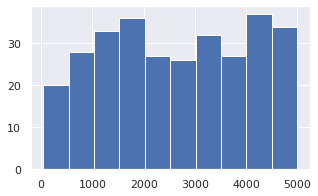

In [12]:
# column 0 (contains continuous values):
df_full_train_transformed[0].hist(
    figsize=(5, 3),
    bins=10,
);

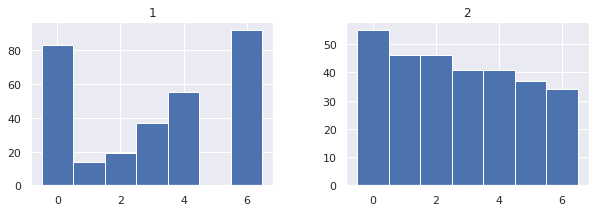

In [13]:
# columns 1, 2 (contain discrete values):
df_full_train_transformed[[1, 2]].hist(
    figsize=(10, 3),
    bins=[x - 0.5 for x in range(8)],
);

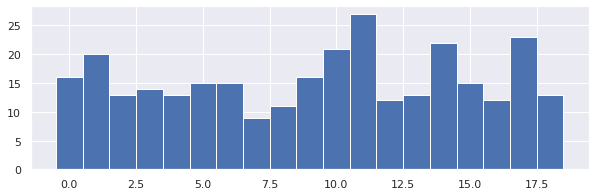

In [14]:
# column 3 (contains discrete values):
df_full_train_transformed[3].hist(
    figsize=(10, 3),
    bins=[x - 0.5 for x in range(20)],
);

We can see no peculiarities in the univariate distributions (the only thing is that `5` is absent in the values of `df_full_train_transformed[1]`).

Multivariate visualizations:

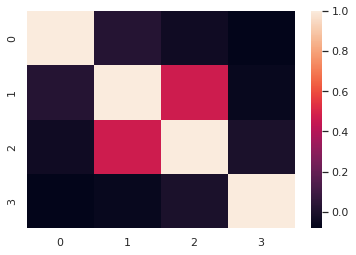

In [15]:
corr_matrix = df_full_train_transformed[range(4)].corr()
sns.heatmap(corr_matrix);

There are no informative correlations between the columns (the correlation between `column1` and `column2` does not have much sense because both columns are discrete and contain only a few unique values).

## 2. Embedding the features into quantum states

We have to embed (encode) the classical data (feature values) to quantum states. We can use the following embeddings implemented in PennyLane:

- `BasisEmbedding`. Encodes $n$ binary features (binary strings of length $n$) into a basis state of $n$ qubits.
- `AmplitudeEmbedding`. Encodes $2^n$ features into the amplitude vector of $n$ qubits.
- `AngleEmbedding`. Encodes $N$ features into the rotation angles of $n$ qubits, where $N \leq n$.
- `IQPEmbedding`. Encodes $n$ features into $n$ qubits using diagonal gates of an IQP circuit.

(We will not consider `QAOAEmbedding`, it is more complicated than the four schemes mentioned above. The number of combinations for 4-feature data is going to be large enough.)

`BasisEmbedding` is only applicable to discrete features. The remaining three embeddings can be used for general numerical features.

We should keep in mind that
- continuous features can be discretized (but this approach triggers loss of information from the very beginning);
- discrete features can be normalized and considered as continuous;
- different feature columns can be embedded using different schemes (in this case we have 'mixed' overall embedding).


Let's have a look at the preprocessed train dataset again (with the target column excluded):

In [16]:
print(df_full_train_transformed[range(4)].info())
df_full_train_transformed[range(4)].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       300 non-null    float64
 1   1       300 non-null    int64  
 2   2       300 non-null    int64  
 3   3       300 non-null    int64  
dtypes: float64(1), int64(3)
memory usage: 9.5 KB
None


,0,1,2,3
count,300.00,300.00,300.00,300.00
mean,2630.88,3.12,2.71,9.23
std,1416.10,2.39,2.00,5.52
min,42.35,0.00,0.00,0.00
25%,1408.07,0.00,1.00,4.00
50%,2672.18,3.00,3.00,10.00
75%,3895.69,6.00,4.00,14.00
max,4995.61,6.00,6.00,18.00


### 2.1 Functions for embedding schemes

The following functions implement different embedding schemes.

In [17]:
def emb_AngBBAng(fs):
    """
    fs[0] -> AngleEmbedding (qubit 0)
    fs[1] -> BasisEmbedding (qubits 1, 2, 3)
    fs[2] -> BasisEmbedding (qubits 4, 5, 6)
    fs[3] -> AngleEmbedding (qubit 7)
    
    fs[0], fs[3] are normalized before applying the embedding.
    """
    fs0_norm = fs[0] / 5000
    fs3_norm = fs[3] / 18
    
    qml.AngleEmbedding(
        features=[fs0_norm * np.pi],
        wires=[0,],
        rotation='X'
    )
    qml.BasisEmbedding(
        features=[int(i) for i in f"{int(fs[1]):03b}"],
        wires=[1,2,3]
    )
    qml.BasisEmbedding(
        features=[int(i) for i in f"{int(fs[2]):03b}"],
        wires=[4,5,6]
    )
    qml.AngleEmbedding(
        features=[fs3_norm * np.pi],
        wires=[7,],
        rotation='X'
    )

In [18]:
def emb_AngBAngAng(fs):
    """
    fs[0] -> AngleEmbedding (qubit 0)
    fs[1] -> BasisEmbedding (qubits 1, 2, 3)
    fs[2] -> AngleEmbedding (qubit 4)
    fs[3] -> AngleEmbedding (qubit 5)
    
    fs[0], fs[2], fs[3] are normalized before applying the embedding.
    """
    fs0_norm = fs[0] / 5000
    fs2_norm = fs[2] / 6
    fs3_norm = fs[3] / 18
    
    qml.AngleEmbedding(
        features=[fs0_norm * np.pi],
        wires=[0,],
        rotation='X'
    )
    qml.BasisEmbedding(
        features=[int(i) for i in f"{int(fs[1]):03b}"],
        wires=[1,2,3]
    )
    qml.AngleEmbedding(
        features=[fs2_norm * np.pi],
        wires=[4,],
        rotation='X'
    )
    qml.AngleEmbedding(
        features=[fs3_norm * np.pi],
        wires=[5,],
        rotation='X'
    )

In [19]:
def emb_AmpBBAmp(fs):
    """
    fs[0], fs[3] -> AmplitudeEmbedding (qubit 0)
    fs[1] -> BasisEmbedding (qubits 1, 2, 3)
    fs[2] -> BasisEmbedding (qubits 4, 5, 6)
    
    fs[0], fs[3] are normalized before applying the embedding.
    """
    fs0_norm = fs[0] / 5000
    fs3_norm = fs[3] / 18
    
    qml.AmplitudeEmbedding(
        features=[fs0_norm, fs3_norm],
        wires=[0,],
        normalize=True
    )
    qml.BasisEmbedding(
        features=[int(i) for i in f"{int(fs[1]):03b}"],
        wires=[1,2,3]
    )
    qml.BasisEmbedding(
        features=[int(i) for i in f"{int(fs[2]):03b}"],
        wires=[4,5,6]
    )

In [20]:
def emb_Amp4(fs):
    """
    fs[0], fs[1], fs[2], fs[3] -> AmplitudeEmbedding (qubits 0, 1)
    
    All fs[] are normalized before applying the embedding.
    """
    fs0_norm = fs[0] / 5000
    fs1_norm = fs[1] / 6
    fs2_norm = fs[2] / 6
    fs3_norm = fs[3] / 18

    qml.AmplitudeEmbedding(
        features=[fs0_norm, fs1_norm, fs2_norm, fs3_norm],
        wires=[0,1],
        normalize=True
    )

In [21]:
def emb_Ang4(fs):
    """
    fs[0] -> AngleEmbedding (qubit 0)
    fs[1] -> AngleEmbedding (qubit 1)
    fs[2] -> AngleEmbedding (qubit 2)
    fs[3] -> AngleEmbedding (qubit 3)
    
    All fs[] are normalized before applying the embedding.
    """
    fs0_norm = fs[0] / 5000
    fs1_norm = fs[1] / 6
    fs2_norm = fs[2] / 6
    fs3_norm = fs[3] / 18
    
    qml.AngleEmbedding(
        features=[fs0_norm * np.pi],
        wires=[0,],
        rotation='X'
    )
    qml.AngleEmbedding(
        features=[fs1_norm * np.pi],
        wires=[1,],
        rotation='X'
    )
    qml.AngleEmbedding(
        features=[fs2_norm * np.pi],
        wires=[2,],
        rotation='X'
    )
    qml.AngleEmbedding(
        features=[fs3_norm * np.pi],
        wires=[3,],
        rotation='X'
    )

In [22]:
def emb_AngAmpAmpAng(fs):
    """
    fs[0] -> AngleEmbedding (qubit 0)
    fs[1], fs[2] -> AmplitudeEmbedding (qubit 1)
    fs[3] -> AngleEmbedding (qubit 2)
    
    All fs[] are normalized before applying the embedding.
    """
    fs0_norm = fs[0] / 5000
    fs1_norm = fs[1] / 6
    fs1_norm += 1
    # ^ important to add a constant because fs1_norm and fs2_norm
    #   cannot be zero simultaneously for AmplitudeEmbedding
    fs2_norm = fs[2] / 6
    fs3_norm = fs[3] / 18
    
    qml.AngleEmbedding(
        features=[fs0_norm * np.pi],
        wires=[0,],
        rotation='X'
    )
    qml.AmplitudeEmbedding(
        features=[fs1_norm, fs2_norm],
        wires=[1,],
        normalize=True
    )
    qml.AngleEmbedding(
        features=[fs3_norm * np.pi],
        wires=[2,],
        rotation='X'
    )

In [23]:
def emb_IQP4(fs):
    """
    All fs[] -> IQPEmbedding (qubits 0, 1, 2, 3)

    All fs[] are normalized before applying the embedding.
    """
    fs0_norm = fs[0] / 5000
    fs1_norm = fs[1] / 6
    fs2_norm = fs[2] / 6
    fs3_norm = fs[3] / 18
    
    qml.IQPEmbedding(
        features=[x * np.pi for x in (fs0_norm, fs1_norm, fs2_norm, fs3_norm)],
        wires=range(4),
    )

## 3. Ansatzes and auxiliary functions

We will consider `BasicEntanglerLayers`, `StronglyEntanglingLayers` and `SimplifiedTwoDesign` as the ansatzes for variational classifiers.

The pipeline and auxiliary functions are written following the [Variational classifier tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html).

We will redefine the function `circuit()` when we choose a different embedding or ansatz. When only the number of layers in an ansatz is changed, redefinition of `circuit()` is not needed.

In [24]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def circuit(weights, features):
    emb_Amp4(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

In [68]:
def variational_classifier(weights, bias, features):
    return circuit(weights, features) + bias


def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss


def cost(weights, bias, features, labels):
    predictions = [
        variational_classifier(weights, bias, f) for f in features
    ]
    return square_loss(labels, predictions)


def accuracy(labels, predictions):
    num_correct = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            num_correct += 1
    
    num_correct /= len(labels)
    return num_correct

Remaining preprocessing of the data is shown below. The `full_train` dataset is split into training and validation sets.

In [26]:
X_full_train = df_full_train_transformed[range(4)].to_numpy()
Y_full_train = df_full_train_transformed[4].to_numpy() * 2 - 1
# ^ transform labels from {0, 1} to {-1, 1}

X_full_train = np.array(X_full_train, requires_grad=False)
Y_full_train = np.array(Y_full_train, requires_grad=False)
# ^ important to have pennylane-numpy tensors!
#   before this, {X,Y}_full_train were ordinary numpy ndarrays

num_full_train = Y_full_train.shape[0]
num_train = int(2 / 3 * num_full_train)
# ^ we use 2/3 of the full_train data for training 
#   and the remaining 1/3 for validation

# fix the seed
np.random.seed(0)

index = np.random.permutation(range(num_full_train))

X_train = X_full_train[index[:num_train]]
Y_train = Y_full_train[index[:num_train]]
X_val = X_full_train[index[num_train:]]
Y_val = Y_full_train[index[num_train:]]

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)

(200, 4) (200,)
(100, 4) (100,)


## 4. Train loop with validation

There are a number of hyperparameters to choose for the train loop and the optimization procedure:
- weight initialization
- optimizer and step size
- training batch size
- number of iterations (optimizer steps)

In order not to consider an enormous number of combinations, we will simply make the choices that seem to be more or less reasonable (the choices made in [Variational classifier tutorial](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html) are presumably good enough). Keep in mind that we have a lot of options for the VQC itself; we should focus on that.

In [41]:
def plot_cost_acc(
    iters_with_acc,
    cost_list,
    acc_train_list,
    acc_val_list,
    plot_title
):
    fig, (ax_cost, ax_acc) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=[12, 3])
    
    ax_cost.plot(iters_with_acc, cost_list, ls='-', label='cost value')
    ax_cost.set_xlabel('iteration')
    ax_cost.set_ylabel('cost value')

    ax_acc.plot(iters_with_acc, acc_train_list, ls='-', label='train accuracy')
    ax_acc.plot(iters_with_acc, acc_val_list, ls='-', label='val accuracy')
    ax_acc.set_ylim(bottom=0, top=1)
    ax_acc.set_xlabel('iteration')
    ax_acc.set_ylabel('accuracy')
    
    ax_acc.legend()
    fig.suptitle(plot_title)
    plt.show()


def train_val_loop(
    weights_shape,
    plot_title,
    w_init_coef=0.01,
    opt_step_size=0.01,
    batch_size=20,
    num_iter=200,
    validate_every=2
):
    weights_init = w_init_coef * np.random.randn(*weights_shape, requires_grad=True)
    bias_init = np.array(0.0, requires_grad=True)

    opt = optimize.NesterovMomentumOptimizer(opt_step_size)
    
    # train the variational classifier
    weights = weights_init
    bias = bias_init

    iters_with_acc = []
    cost_list = []
    acc_train_list = []
    acc_val_list = []

    for i in tqdm(range(num_iter)):
        batch_index = np.random.randint(0, num_train, (batch_size,))
        X_train_batch = X_train[batch_index]
        Y_train_batch = Y_train[batch_index]
        # Update the weights by one optimizer step
        weights, bias, _, _ = opt.step(cost, weights, bias, X_train_batch, Y_train_batch)

        if i % validate_every == 0:
            iters_with_acc.append(i)
            
            # Compute predictions on train and validation set
            predictions_train = [
                np.sign(variational_classifier(weights, bias, f)) for f in X_train
            ]
            predictions_val = [
                np.sign(variational_classifier(weights, bias, f)) for f in X_val
            ]

            cost_list.append(cost(weights, bias, X_full_train, Y_full_train))
            # Compute accuracy on train and validation set
            acc_train_list.append(accuracy(Y_train, predictions_train))
            acc_val_list.append(accuracy(Y_val, predictions_val))
    
    plot_cost_acc(iters_with_acc, cost_list, acc_train_list, acc_val_list, plot_title)
    return weights, bias

## 5. Experiments and intermediate results

The pipeline is ready. Next, we are going to perform a variety of experiments using different embedding schemes and different ansatzes with different numbers of layers.

I think the embedding scheme is much more important to the trainability and performance of a classifier than the particular design choices of the ansatz (provided that the ansatz choice is 'reasonable'). Let me expand on that. Suppose we have selected a family of ansatzes that satisfy the following criteria:
- the number of parameters is not too small (hopefully the ansatz is expressive enough);
- the number of layers is not too large (hopefully the optimization process will not get stuck in a barren plateau).

For such a family of ansatzes, the trainability and performance of classifiers should (intuitively) be comparable if the same embedding scheme is used (global properties should not be sensitive to minor changes in the construction of the ansatz).

So, for the first series of experiments we will choose one embedding scheme and try combining it with `BasicEntanglerLayers` ansatz with different numbers of layers (presumably a 'reasonable' overall ansatz will be present in the list). 

### 5.1 The `Amp4` embedding

  0%|          | 0/200 [00:00<?, ?it/s]

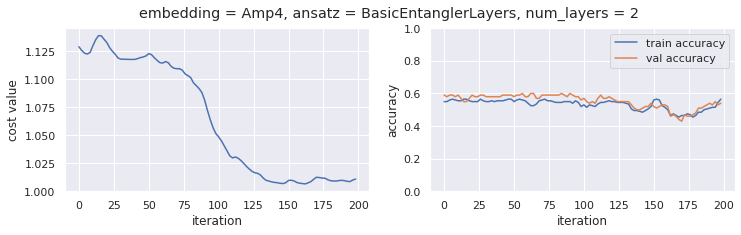

  0%|          | 0/200 [00:00<?, ?it/s]

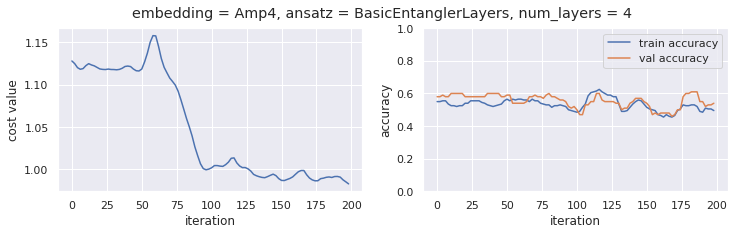

  0%|          | 0/200 [00:00<?, ?it/s]

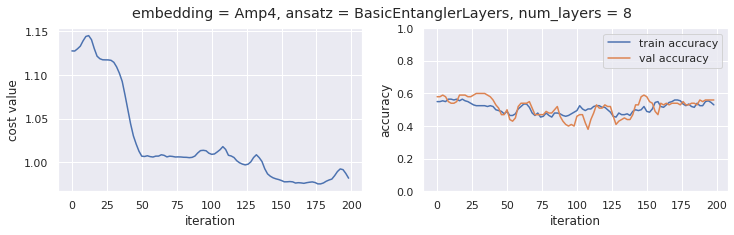

In [30]:
for num_layers in (2, 4, 8):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        plot_title=f"embedding = Amp4, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

The `Amp4` embedding is no good. The classifier is not trainable for 2, 4, 8 layers in the ansatz.

### 5.2 The `Ang4` embedding

In [31]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(weights, features):
    emb_Ang4(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

  0%|          | 0/200 [00:00<?, ?it/s]

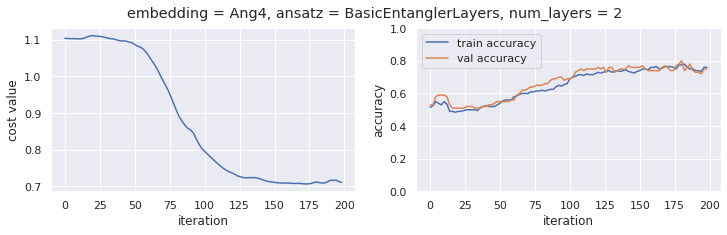

  0%|          | 0/200 [00:00<?, ?it/s]

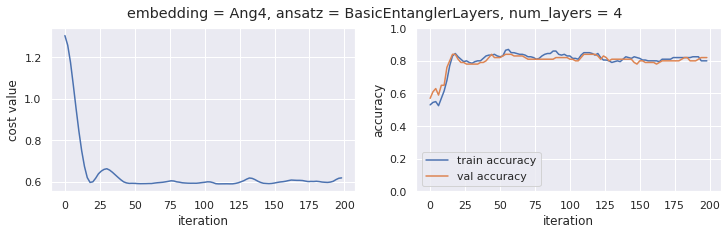

In [32]:
for num_layers in (2, 4):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        plot_title=f"embedding = Ang4, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

This embedding looks promising! For a 4-layer ansatz, accuracy > 80% can be reached. We will get back to the `Ang4` embedding later.

### 5.3 The `AngAmpAmpAng` embedding

In [33]:
dev = qml.device('default.qubit', wires=3)

@qml.qnode(dev)
def circuit(weights, features):
    emb_AngAmpAmpAng(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

  0%|          | 0/200 [00:00<?, ?it/s]

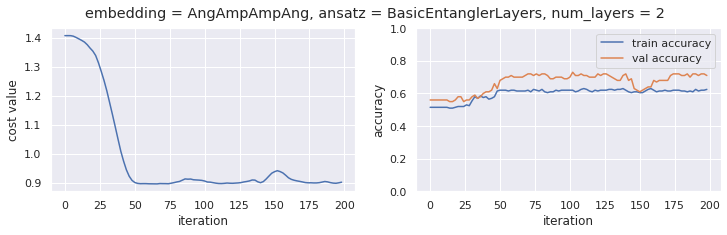

  0%|          | 0/200 [00:00<?, ?it/s]

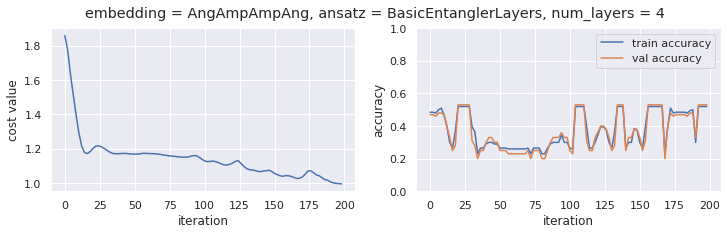

  0%|          | 0/200 [00:00<?, ?it/s]

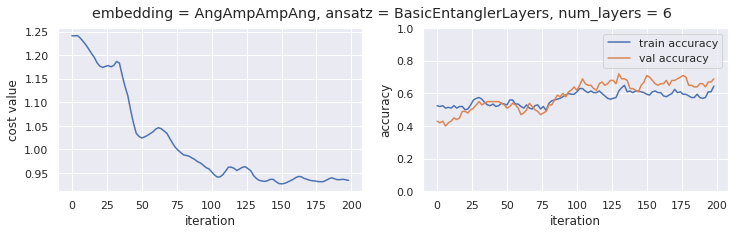

In [34]:
for num_layers in (2, 4, 6):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        plot_title=f"embedding = AngAmpAmpAng, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

The results are definitely worse than the `Ang4`'s results (the cost value cannot reduce to the levels observed for `Ang4`). Maybe amplitude embedding for any feature columns is inappropriate for the task at hand. We will not use amplitude embedding for the subsequent experiments.

### 5.4 The `AngBBAng` embedding

In [35]:
dev = qml.device('default.qubit', wires=8)

@qml.qnode(dev)
def circuit(weights, features):
    emb_AngBBAng(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

  0%|          | 0/200 [00:00<?, ?it/s]

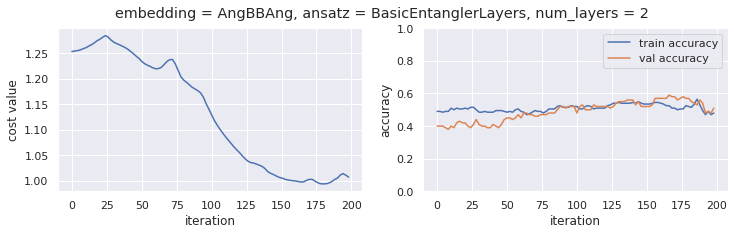

  0%|          | 0/200 [00:00<?, ?it/s]

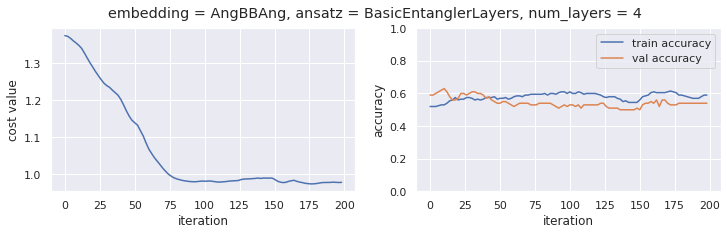

  0%|          | 0/200 [00:00<?, ?it/s]

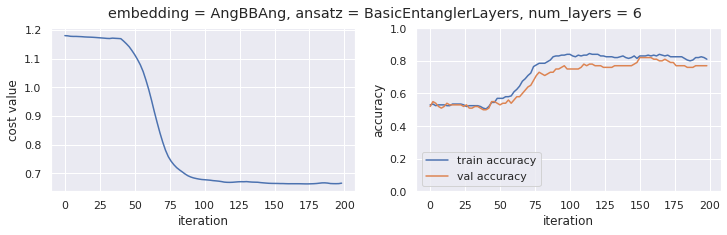

In [36]:
for num_layers in (2, 4, 6):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        plot_title=f"embedding = AngBBAng, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

The `AngBBAng` embedding can lead to acceptable results for relatively large `num_layers`. (I decided not to run the training loop for `num_layers=8` because it will take long.)

### 5.5 The `AngBAngAng` embedding

In [37]:
dev = qml.device('default.qubit', wires=6)

@qml.qnode(dev)
def circuit(weights, features):
    emb_AngBAngAng(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

  0%|          | 0/200 [00:00<?, ?it/s]

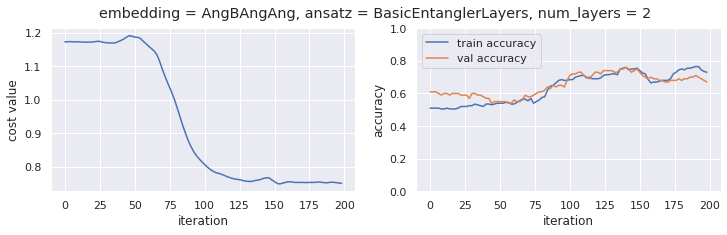

  0%|          | 0/200 [00:00<?, ?it/s]

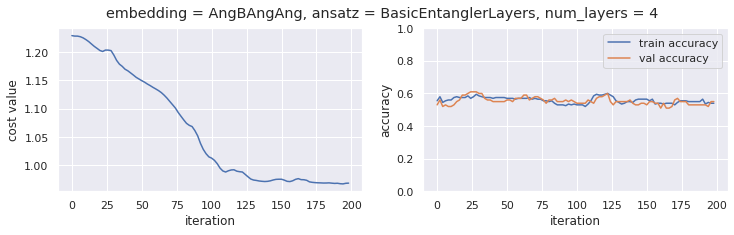

  0%|          | 0/200 [00:00<?, ?it/s]

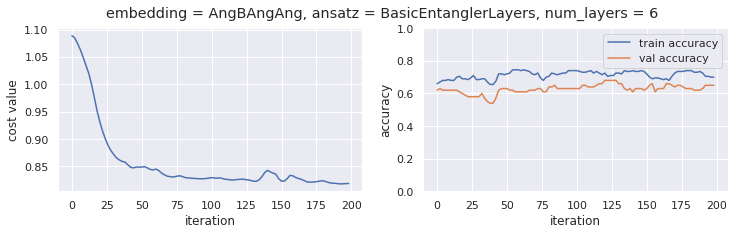

In [38]:
for num_layers in (2, 4, 6):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        plot_title=f"embedding = AngBAngAng, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

The results for `AngBAngAng` seem to be worse than that for both `Ang4` and `AngBBAng`.

### 5.6 The `IQP4` embedding

In [39]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(weights, features):
    emb_IQP4(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

  0%|          | 0/200 [00:00<?, ?it/s]

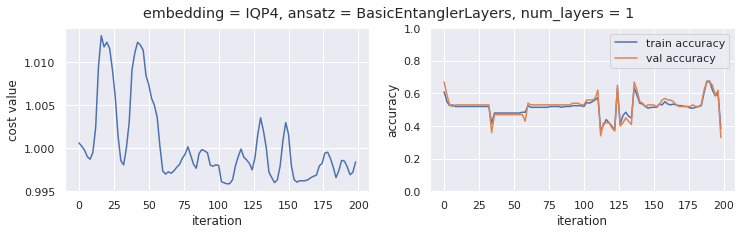

  0%|          | 0/200 [00:00<?, ?it/s]

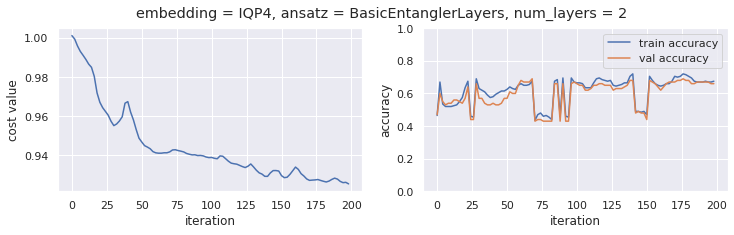

  0%|          | 0/200 [00:00<?, ?it/s]

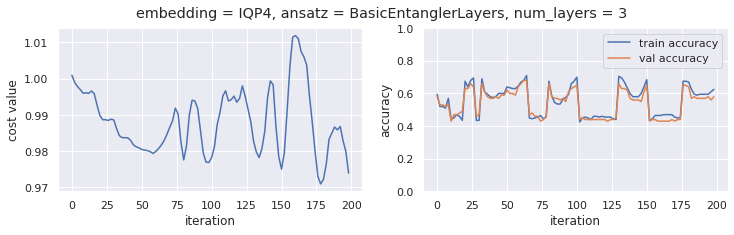

  0%|          | 0/200 [00:00<?, ?it/s]

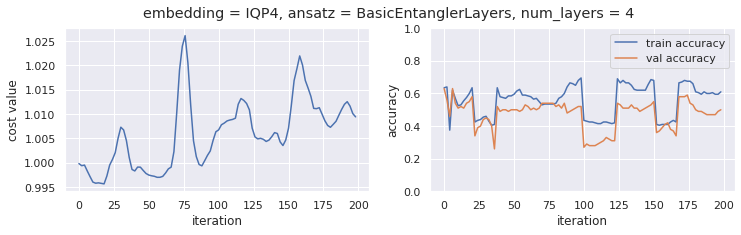

  0%|          | 0/200 [00:00<?, ?it/s]

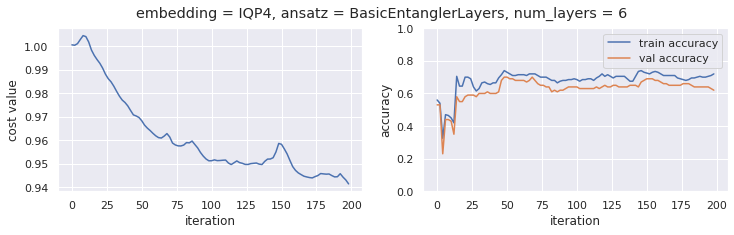

In [40]:
for num_layers in (1, 2, 3, 4, 6):
    train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        plot_title=f"embedding = IQP4, ansatz = BasicEntanglerLayers, num_layers = {num_layers}"
    )

We see very limited success with the `IQP4` embedding. Maybe it's possible to obtain good results with it after careful tuning (`IQPEmbedding` supports specifying the number of repeats of the basic IQP circuit, and a custom pattern can be provided) and setting sufficiently large `num_layers`. A number of additional experiments would be required for `IQPEmbedding` tuning.

But let's better focus on the `Ang4` embedding. It is relatively simple, and we were able to achieve good results for it right away (the results are better than that of the `IQP4` embedding).

### 5.7 The `Ang4` embedding: looking for good ansatzes

In the following experiments, the Ang4 embedding is used with different ansatzes (and numbers of layers).

### 5.7.1 `BasicEntanglerLayers`

In [73]:
dev = qml.device('default.qubit', wires=4)

@qml.qnode(dev)
def circuit(weights, features):
    emb_Ang4(features)

    qml.BasicEntanglerLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

  0%|          | 0/200 [00:00<?, ?it/s]

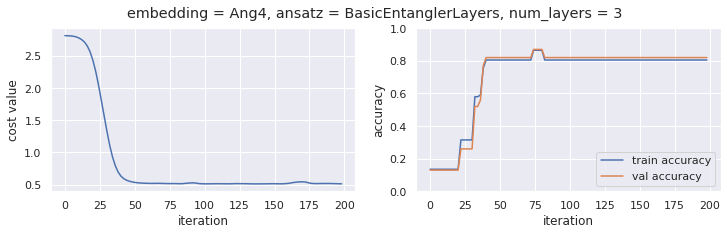

  0%|          | 0/200 [00:00<?, ?it/s]

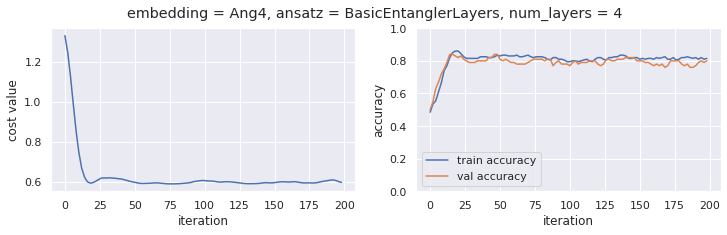

  0%|          | 0/200 [00:00<?, ?it/s]

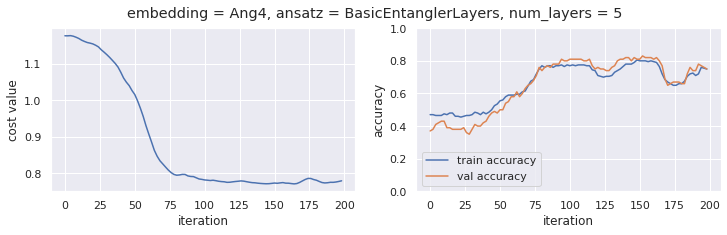

  0%|          | 0/200 [00:00<?, ?it/s]

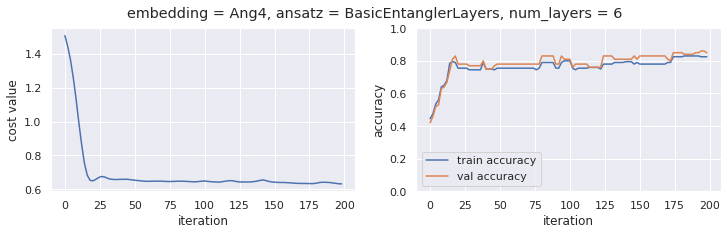

In [43]:
weights_biases = {}

for num_layers in (3, 4, 5, 6):
    weights, bias = train_val_loop(
        weights_shape=(num_layers, dev.num_wires),
        plot_title=f"embedding = Ang4, ansatz = BasicEntanglerLayers, num_layers = {num_layers}",
    )
    weights_biases[num_layers] = (weights, bias)

`num_layers` equal to 3, 4, 6 are good for `BasicEntanglerLayers`. Let's check the accuracy on the test set for the classifier corresponding to `num_layers = 6`:

In [74]:
df_test_transformed = transform_dataframe_1(df_test)
X_test = df_test_transformed[range(4)].to_numpy()
Y_test = df_test_transformed[4].to_numpy() * 2 - 1

weights, bias = weights_biases[6]
predictions_test = [
    np.sign(variational_classifier(weights, bias, f)) for f in X_test
]

acc_test = accuracy(Y_test, predictions_test)
print(f"Test accuracy: {acc_test:.3f}")

Test accuracy: 0.900


### 5.7.2 `StronglyEntanglingLayers`

In [75]:
@qml.qnode(dev)
def circuit(weights, features):
    emb_Ang4(features)

    qml.StronglyEntanglingLayers(weights, wires=range(dev.num_wires))

    return qml.expval(qml.PauliZ(0))

  0%|          | 0/200 [00:00<?, ?it/s]

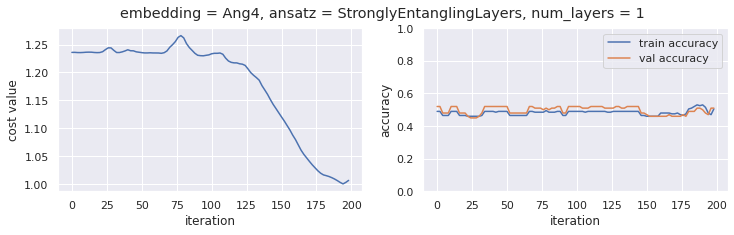

  0%|          | 0/200 [00:00<?, ?it/s]

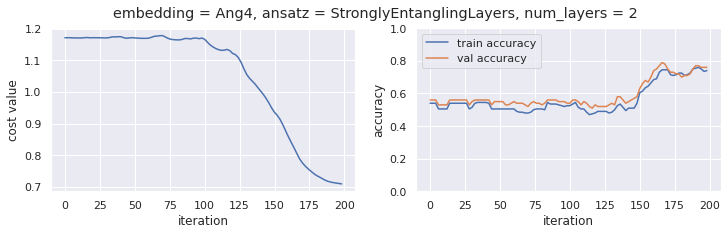

  0%|          | 0/200 [00:00<?, ?it/s]

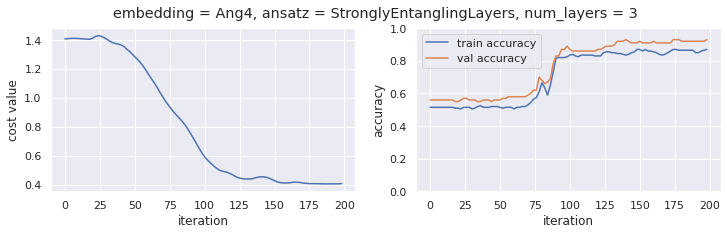

  0%|          | 0/200 [00:00<?, ?it/s]

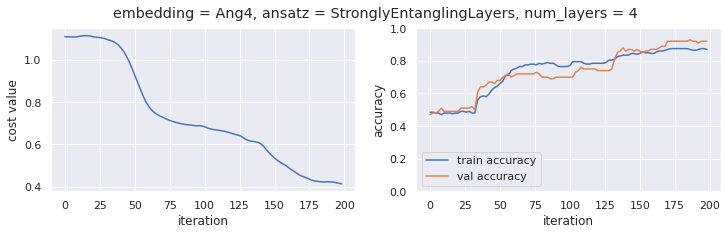

  0%|          | 0/200 [00:00<?, ?it/s]

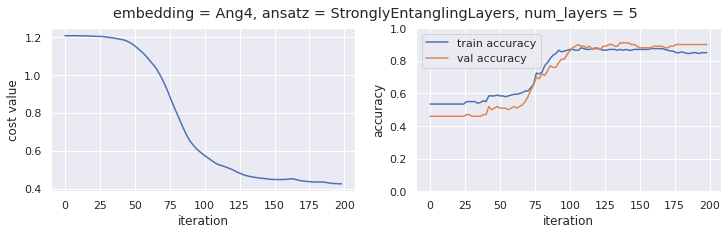

In [46]:
weights_biases_strong = {}

for num_layers in (1, 2, 3, 4, 5):
    weights, bias = train_val_loop(
        weights_shape=(num_layers, dev.num_wires, 3),
        plot_title=f"embedding = Ang4, ansatz = StronglyEntanglingLayers, num_layers = {num_layers}",
    )
    weights_biases_strong[num_layers] = (weights, bias)

`num_layers` equal to 3, 4, 5 are good for `StronglyEntanglingLayers`. Let's check the accuracy on the test set for the classifier corresponding to `num_layers = 5`:

In [76]:
weights, bias = weights_biases_strong[5]
predictions_test = [
    np.sign(variational_classifier(weights, bias, f)) for f in X_test
]

acc_test = accuracy(Y_test, predictions_test)
print(f"Test accuracy: {acc_test:.3f}")

Test accuracy: 0.983


### 5.7.3 `SimplifiedTwoDesign`

The `SimplifiedTwoDesign` ansatz requires two different weight tensors (the first one is for an initial layer of single qubit Pauli-Y rotations, the second one is for a repeated block of controlled-Z entanglers). All our auxiliary functions were written in such a way that the weights are passed as a single tensor (for simplicity). For `SimplifiedTwoDesign`, we pass a single tensor that is 'unpacked' / 'splitted' in a particular way shown below.

In [77]:
@qml.qnode(dev)
def circuit(weights, features):
    emb_Ang4(features)
    
    # weights.shape == (L+1, M, 2),
    # where L = number of layers, M = number of wires
    w1 = weights[-1, :, 0]
    # w1.shape == (M,)
    w2 = weights[:-1, :-1, :]
    # w2.shape == (L, M-1, 2)
    
    qml.SimplifiedTwoDesign(
        initial_layer_weights=w1,
        weights=w2,
        wires=range(dev.num_wires)
    )

    return qml.expval(qml.PauliZ(0))

  0%|          | 0/200 [00:00<?, ?it/s]

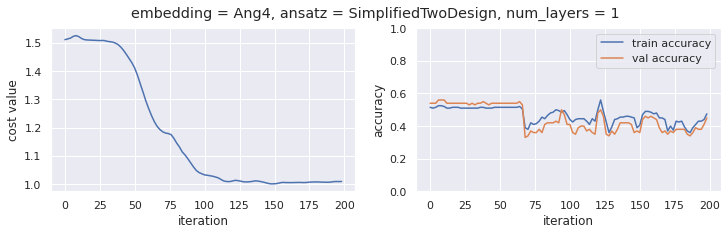

  0%|          | 0/200 [00:00<?, ?it/s]

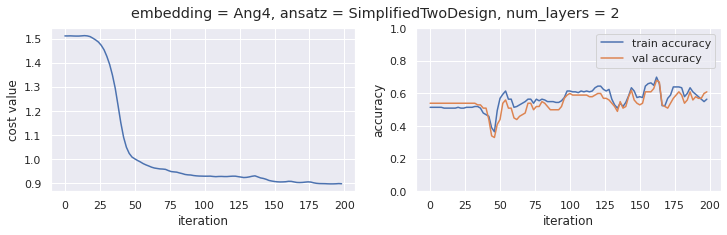

  0%|          | 0/200 [00:00<?, ?it/s]

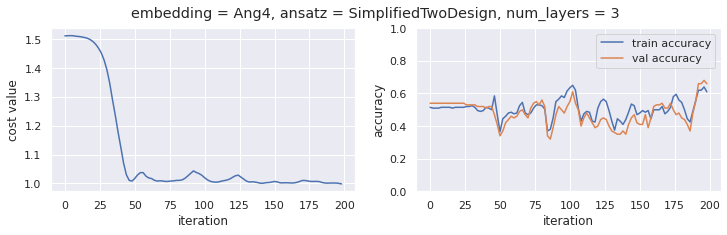

  0%|          | 0/200 [00:00<?, ?it/s]

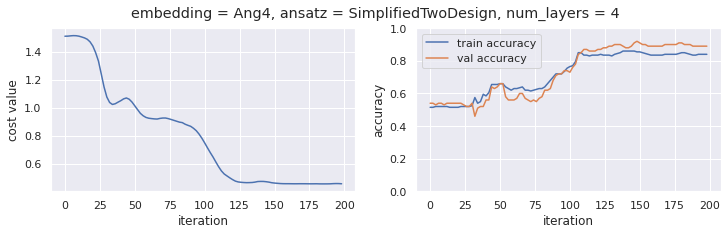

  0%|          | 0/200 [00:00<?, ?it/s]

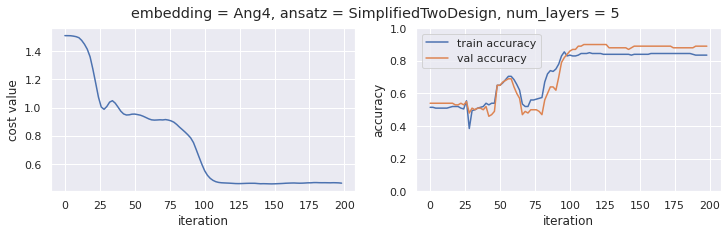

In [48]:
weights_biases_2des = {}

for num_layers in (1, 2, 3, 4, 5):
    weights, bias = train_val_loop(
        weights_shape=(num_layers + 1, dev.num_wires, 2),
        plot_title=f"embedding = Ang4, ansatz = SimplifiedTwoDesign, num_layers = {num_layers}",
    )
    weights_biases_2des[num_layers] = (weights, bias)

`num_layers` equal to 4, 5 are good for `SimplifiedTwoDesign`. The accuracy on the test set for the classifier corresponding to `num_layers = 5`:

In [78]:
weights, bias = weights_biases_2des[5]
predictions_test = [
    np.sign(variational_classifier(weights, bias, f)) for f in X_test
]

acc_test = accuracy(Y_test, predictions_test)
print(f"Test accuracy: {acc_test:.3f}")

Test accuracy: 0.983


## 6. The kernel embedding and Support Vector Classifier

Here we closely follow the tutorial [Training and evaluating quantum kernels](https://pennylane.ai/qml/demos/tutorial_kernels_module.html).

In [79]:
from sklearn.svm import SVC

In [80]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % len(x)], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    if len(wires) == 2:
        ptrn = "chain"
        p = params[1][:-1]
    else:
        ptrn = "ring"
        p = params[1]
    
    qml.broadcast(unitary=qml.CRZ, pattern=ptrn, wires=wires, parameters=p)
    
    
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=(j * len(wires)))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, 2, num_wires), requires_grad=True)

## 6.1 SVM for fixed kernel with random weights

The function `svm_random_weights()` below wraps together 
- definition of the device,
- kernel-related functions,
- definition, fitting and evaluating the SVM classifier.

In [83]:
def accuracy(classifier, X, Y_target):
    return 1 - np.count_nonzero(classifier.predict(X) - Y_target) / len(Y_target)


def svm_random_weights(num_qubits, ansatz_num_layers):
    dev = qml.device("default.qubit", wires=num_qubits, shots=None)
    wires = dev.wires.tolist()

    @qml.qnode(dev)
    def kernel_circuit(x1, x2, params):
        ansatz(x1, params, wires=wires)
        adjoint_ansatz(x2, params, wires=wires)
        return qml.probs(wires=wires)


    def kernel(x1, x2, params):
        return kernel_circuit(x1, x2, params)[0]


    init_params = random_params(num_wires=dev.num_wires, num_layers=ansatz_num_layers)
    init_kernel = lambda x1, x2: kernel(x1, x2, init_params)

    classifier = SVC(
        kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel)
    )
    svm = classifier.fit(X_train, Y_train)


    accuracy_init_train = accuracy(svm, X_train, Y_train)
    accuracy_init_val = accuracy(svm, X_val, Y_val)
    print(f"The accuracy values for the kernel with random parameters are:")
    print(f"  train: {accuracy_init_train:.3f}")
    print(f"    val: {accuracy_init_val:.3f}")
    return svm

Let's choose the number of qubits equal to the number of feature columns: `num_qubits=4`.

For now, let's set `num_layers=1` in order to avoid very time-consuming fitting and prediction.

In [52]:
svm_4_1 = svm_random_weights(num_qubits=4, ansatz_num_layers=1)

The accuracy values for the kernel with random parameters are:
  train: 0.900
    val: 0.790


The accuracy values are quite high, but there is a substantial gap between the metrics on the train set and the validation set. It is a sign of overfitting. Let's try reducing the number of qubits to 2:

In [53]:
svm_2_1 = svm_random_weights(num_qubits=2, ansatz_num_layers=1)

The accuracy values for the kernel with random parameters are:
  train: 0.700
    val: 0.660


The metrics for train set and val set became closer, but both of them reduced substantially.

What about the case `num_qubits=3`?

In [84]:
svm_3_1 = svm_random_weights(num_qubits=3, ansatz_num_layers=1)

The accuracy values for the kernel with random parameters are:
  train: 0.840
    val: 0.780


The metrics values for `num_qubits=3` lie between the corresponding values for `num_qubits=4` and `num_qubits=2`, as expected.

The test accuracy for the case `num_qubits=3`, `ansatz_num_layers=1` is:

In [85]:
accuracy_init_test = accuracy(svm_3_1, X_test, Y_test)
print(f"The accuracy value for the kernel with random parameters is:")
print(f"   test: {accuracy_init_test:.3f}")

The accuracy value for the kernel with random parameters is:
   test: 0.858


What about increasing the number of layers?

In [55]:
svm_3_2 = svm_random_weights(num_qubits=3, ansatz_num_layers=2)

The accuracy values for the kernel with random parameters are:
  train: 0.815
    val: 0.670


In [82]:
svm_3_3 = svm_random_weights(num_qubits=3, ansatz_num_layers=3)

The accuracy values for the kernel with random parameters are:
  train: 0.805
    val: 0.670


Overfitting becomes more pronounced for the increased number of layers.

## 6.2 Optimization for kernel-target alignment

Next, we will run an optimization loop to increase the kernel-target alignment (KTA) value (as shown in the [tutorial](https://pennylane.ai/qml/demos/tutorial_kernels_module.html)).

In [56]:
def target_alignment(
    X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / nplus if y == 1 else y / nminus for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / norm

    return inner_product

In [57]:
def kta_optim_loop(
    num_qubits,
    ansatz_num_layers,
    optim_step_size=0.2,
    batch_size=5,
    print_alignment_every=50,
):
    dev = qml.device("default.qubit", wires=num_qubits, shots=None)
    wires = dev.wires.tolist()

    @qml.qnode(dev)
    def kernel_circuit(x1, x2, params):
        ansatz(x1, params, wires=wires)
        adjoint_ansatz(x2, params, wires=wires)
        return qml.probs(wires=wires)

    def kernel(x1, x2, params):
        return kernel_circuit(x1, x2, params)[0]

    params = random_params(num_wires=dev.num_wires, num_layers=ansatz_num_layers)
    opt = qml.GradientDescentOptimizer(optim_step_size)
    
    current_alignment = target_alignment(
        X_train,
        Y_train,
        lambda x1, x2: kernel(x1, x2, params),
        assume_normalized_kernel=True,
    )
    print(f"Initially: Alignment = {current_alignment:.3f}")
    
    for i in range(500):
        # Choose subset of datapoints to compute the KTA on.
        subset = np.random.choice(list(range(X_train.shape[0])), batch_size)
        # Define the cost function for optimization
        cost = lambda _params: -target_alignment(
            X_train[subset],
            np.array(Y_train[subset], requires_grad=True),
            # ^ Passing simply Y_train[subset] (which has requires_grad=False)
            #   causes opt.step() to fail with NonDifferentiableError.
            #   That's strange. Maybe a bug in PennyLane.
            lambda x1, x2: kernel(x1, x2, _params),
            assume_normalized_kernel=True,
        )
        # Optimization step
        params = opt.step(cost, params)

        # Report the alignment on the full dataset every 50 steps.
        if (i + 1) % print_alignment_every == 0:
            current_alignment = target_alignment(
                X_train,
                Y_train,
                lambda x1, x2: kernel(x1, x2, params),
                assume_normalized_kernel=True,
            )
            print(f"Step {i+1:04d}: Alignment = {current_alignment:.3f}")
    
    return params

In [58]:
params = kta_optim_loop(
    num_qubits=3,
    ansatz_num_layers=1,
    batch_size=5
)

Initially: Alignment = 0.141
Step 0050: Alignment = 0.141
Step 0100: Alignment = 0.141
Step 0150: Alignment = 0.141
Step 0200: Alignment = 0.141
Step 0250: Alignment = 0.141
Step 0300: Alignment = 0.141
Step 0350: Alignment = 0.141
Step 0400: Alignment = 0.141
Step 0450: Alignment = 0.141
Step 0500: Alignment = 0.141


^ The cost function for the KTA is not trainable for the hyperparameters chosen.
Let's try a deeper ansatz.

In [59]:
params = kta_optim_loop(
    num_qubits=3,
    ansatz_num_layers=2,
    batch_size=10
)

Initially: Alignment = 0.054
Step 0050: Alignment = 0.058
Step 0100: Alignment = 0.062
Step 0150: Alignment = 0.066
Step 0200: Alignment = 0.069
Step 0250: Alignment = 0.074
Step 0300: Alignment = 0.076
Step 0350: Alignment = 0.079
Step 0400: Alignment = 0.080
Step 0450: Alignment = 0.082
Step 0500: Alignment = 0.086


In [60]:
params3 = kta_optim_loop(
    num_qubits=3,
    ansatz_num_layers=3,
    batch_size=10
)

Initially: Alignment = 0.064
Step 0050: Alignment = 0.070
Step 0100: Alignment = 0.074
Step 0150: Alignment = 0.079
Step 0200: Alignment = 0.079
Step 0250: Alignment = 0.082
Step 0300: Alignment = 0.084
Step 0350: Alignment = 0.085
Step 0400: Alignment = 0.084
Step 0450: Alignment = 0.087
Step 0500: Alignment = 0.089


The kernel target alignment became trainable. The rate of increasing is slow, though. And the optimization loop took a long time. So, let's stop at this point. We have a kind of a 'proof-of-concept' now (the KTA is trainable in principle).

What is the impact of training the parameters of the quantum kernel? Let's build an SVC for the trained kernel (`num_qubits=3`, `ansatz_num_layers=3`).

In [61]:
dev = qml.device("default.qubit", wires=3, shots=None)
wires = dev.wires.tolist()

@qml.qnode(dev)
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    return qml.probs(wires=wires)

def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)[0]
    
# Create a kernel with the trained parameter baked into it
trained_kernel = lambda x1, x2: kernel(x1, x2, params3)

# Create a kernel matrix function using the trained kernel
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function
svm_trained = SVC(kernel=trained_kernel_matrix).fit(X_train, Y_train)

accuracy_trained_train = accuracy(svm_trained, X_train, Y_train)
accuracy_trained_val = accuracy(svm_trained, X_val, Y_val)
print(f"The accuracy values for the kernel with trained parameters are:")
print(f"  train: {accuracy_trained_train:.3f}")
print(f"    val: {accuracy_trained_val:.3f}")

The accuracy values for the kernel with trained parameters are:
  train: 0.845
    val: 0.640


For the corresponding fixed kernel, the results were the following: `train: 0.805`, `val: 0.670`. Optimizing the KTA increased the accuracy on train set, but the generalization ability decreased.

## 7. Summary

1. Exploratory data analysis and preprocessing is really important. If there is a feature with discrete values (and the number of unique values is not large), one can try to apply `BasisEmbedding` designated for binary strings, but it is definitely possible to ignore the discreteness and apply `AngleEmbedding`, `AmplitudeEmbedding`, `IQPEmbedding` etc. For continuous features, it is common to use the 'continuous' embeddings like the ones listed above, but in principle it is possible to discretize the feature values and apply `BasisEmbedding` (I have not tried that for the classification task at hand). Of course, mixing (choosing different embeddings for different feature columns) is possible, too.

2. Experiments show that the angle embedding works best for the task at hand. The amplitude embedding showed poor results. Limited success was achieved for the basis and IQP embeddings. These are the results obtained after a quick investigation and only a few experiments; in order to make more reliable conclusions, one should conduct a more thorough research with hyperparameter tuning, trying more combinations of different embeddings for different features, etc.

3. For the angle embedding (`Ang4`), good results (accuracy > 80% for train, val, test sets) were achieved for all three chosen ansatzes (based on `BasicEntanglerLayers`, `StronglyEntanglingLayers` and `SimplifiedTwoDesign`). 'Good' numbers of layers (according to a limited number of experiments) are
    * `num_layers` = 3, 4, 6 for `BasicEntanglerLayers`;
    * `num_layers` = 3, 4, 5 for `StronglyEntanglingLayers`;
    * `num_layers` = 4, 5 for `SimplifiedTwoDesign`.

4. I have run a few experiments for the kernel embedding. For some fixed kernels with random weights, the results (accuracy values) are relatively good. But optimizing the kernel-target alignment (KTA) was not successful. More experiments should be conducted (unfortunately, I do not have the time for that).